In [1]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import pyproj
from tqdm import tqdm
import numpy as np

In [2]:
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [21]:
from geopy.distance import geodesic

In [3]:
# check python version and all packages version
def check_python_version():
    import sys
    print("Python version")
    print (sys.version)
    print("Pandas version")
    print(pd.__version__)
    print("Geopandas version")
    print(gpd.__version__)
    print("Xarray version")
    print(xr.__version__)
    print("Pyproj version")
    print(pyproj.__version__)

check_python_version()

Python version
3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]
Pandas version
2.2.2
Geopandas version
0.14.2
Xarray version
2023.6.0
Pyproj version
3.6.1


In [4]:
pd.set_option('display.max_colwidth', None)

In [77]:
location_dat = pd.read_parquet('../Clean_Data/Weather_Data_w_Veg_Filter/wind_speed_filtered.parquet')[['lon', 'lat']]
# deduplicate
location_dat = location_dat.drop_duplicates()

In [78]:
# reindex the data
location_dat = location_dat.reset_index(drop=True)

In [14]:
location_dat.shape

(17703, 2)

In [15]:
location_dat.head()

,lon,lat
0,-124.391667,40.441667
1,-124.391667,40.400000
2,-124.350000,40.566667
3,-124.350000,40.525000
4,-124.350000,40.483333


In [16]:
# read fire data
fire_data_location = pd.read_parquet('../Clean_Data/fire_data_map_weather_lon_lat.parquet')[['lon', 'lat']]
# deduplicate
fire_data_location = fire_data_location.drop_duplicates()
# reindex the data
fire_data_location = fire_data_location.reset_index(drop=True)

In [17]:
fire_data_location.head()

,lon,lat
0,-122.891667,41.525000
1,-121.975000,39.816667
2,-120.891667,38.275000
3,-120.975000,38.441667
4,-121.016667,38.233333


In [20]:
fire_data_location.shape

(4862, 2)

In [22]:
from scipy.spatial import cKDTree

# Create a KDTree for the vegetation_dat coordinates
tree = cKDTree(fire_data_location[['lat', 'lon']].values)

# Query the nearest neighbors for each point in location_dat
approx_distances, indices = tree.query(location_dat[['lat', 'lon']].values, k=1)

In [23]:
# Calculate the exact geodesic distances
exact_distances = []
for i, idx in enumerate(indices):
    coords_1 = (location_dat.iloc[i]['lat'], location_dat.iloc[i]['lon'])
    coords_2 = (fire_data_location.iloc[idx]['lat'], fire_data_location.iloc[idx]['lon'])
    distance = geodesic(coords_1, coords_2).km
    exact_distances.append(distance)

# Convert exact_distances to a numpy array
exact_distances = np.array(exact_distances)

In [24]:
exact_distances.min(), exact_distances.max()

(0.0, 85.40382311376695)

In [79]:
# Filter out distances greater than 10 km
mask = exact_distances < 12
# Assign the nearest type and distance to lon_lat_combinations
# location_dat['type'] = np.where(mask, fire_data_location.iloc[indices]['type'].values, np.nan)
location_dat['distance'] = np.where(mask, exact_distances, np.nan)

In [80]:
# check missing % of distance
location_dat['distance'].isnull().mean()

0.09399536801672033

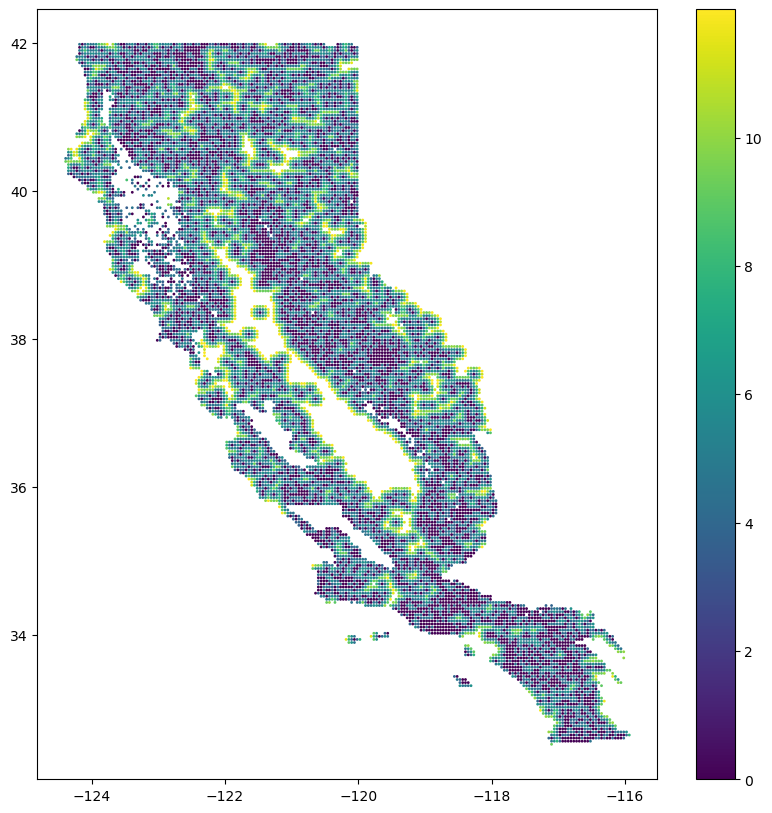

In [81]:
# 12km
plt.figure(figsize=(10, 10))
plt.scatter(location_dat['lon'], location_dat['lat'], c=location_dat['distance'], cmap='viridis', s = 1)
plt.colorbar()
plt.show()

10% of grids will be removed from final analysis

In [82]:
# remove missing distance
location_dat = location_dat.dropna(subset=['distance'])
# drop column distance
location_dat = location_dat.drop(columns=['distance'])

In [83]:
location_dat.head()

,lon,lat
0,-124.391667,40.441667
1,-124.391667,40.400000
2,-124.350000,40.566667
3,-124.350000,40.525000
4,-124.350000,40.483333


In [84]:
# print if there is any duplicated
location_dat.duplicated().sum()

0

In [86]:
files = os.listdir('../Clean_Data/Weather_Data_w_Veg_Filter/')
files

['dead_fuel_moisture_1000hr_filtered.parquet',
 'dead_fuel_moisture_100hr_filtered.parquet',
 'expanded_Palmer_Drought_Severity_Index_filtered.parquet',
 'max_air_temperature_filtered.parquet',
 'max_relative_humidity_filtered.parquet',
 'max_wind_speed_filtered.parquet',
 'min_air_temperature_filtered.parquet',
 'min_relative_humidity_filtered.parquet',
 'precipitation_amount_filtered.parquet',
 'specific_humidity_filtered.parquet',
 'surface_downwelling_shortwave_flux_filtered.parquet',
 'wind_from_direction_filtered.parquet',
 'wind_speed_filtered.parquet']

In [88]:
# read each saved parquet file
for file in files:
    # print the file name
    print(file)
    panda_df = pd.read_parquet(f'../Clean_Data/Weather_Data_w_Veg_Filter/{file}')
    # merge the dataframes
    merged_df = pd.merge(panda_df, location_dat, on=['lon', 'lat'], how='inner')
    # save the merged dataframe
    merged_df.to_parquet(f'../Clean_Data/Weather_Data_w_Veg_Filter_Fire_12KM/{file}')
    # print the shape of the merged dataframe before and after
    print(panda_df.shape, merged_df.shape)

dead_fuel_moisture_1000hr_filtered.parquet
(148705200, 4) (134727600, 4)
dead_fuel_moisture_100hr_filtered.parquet
(148705200, 4) (134727600, 4)
expanded_Palmer_Drought_Severity_Index_filtered.parquet
(148705200, 5) (134727600, 5)
max_air_temperature_filtered.parquet
(148705200, 4) (134727600, 4)
max_relative_humidity_filtered.parquet
(148705200, 4) (134727600, 4)
max_wind_speed_filtered.parquet
(148705200, 4) (134727600, 4)
min_air_temperature_filtered.parquet
(148705200, 4) (134727600, 4)
min_relative_humidity_filtered.parquet
(148705200, 4) (134727600, 4)
precipitation_amount_filtered.parquet
(148705200, 4) (134727600, 4)
specific_humidity_filtered.parquet
(148705200, 4) (134727600, 4)
surface_downwelling_shortwave_flux_filtered.parquet
(148705200, 4) (134727600, 4)
wind_from_direction_filtered.parquet
(148705200, 4) (134727600, 4)
wind_speed_filtered.parquet
(148705200, 4) (134727600, 4)


In [90]:
merged_df.head()

,lon,lat,day,wind_speed
0,-124.391667,40.441667,2001-01-01,4.8
1,-124.391667,40.441667,2001-01-02,2.1
2,-124.391667,40.441667,2001-01-03,3.3
3,-124.391667,40.441667,2001-01-04,2.0
4,-124.391667,40.441667,2001-01-05,4.2


In [89]:
134727600/148705200

0.9060046319832796

In [91]:
# read all the saved parquet files, merge them and save them
files = os.listdir('../Clean_Data/Weather_Data_w_Veg_Filter_Fire_12KM/')
# read the first file
all_features = pd.read_parquet(f'../Clean_Data/Weather_Data_w_Veg_Filter_Fire_12KM/{files[0]}')
# read the rest of the files
for file in files[1:]:
    # read the file
    panda_df = pd.read_parquet(f'../Clean_Data/Weather_Data_w_Veg_Filter_Fire_12KM/{file}')
    print(all_features.shape)
    all_features = pd.merge(all_features, panda_df, on=['lon', 'lat', 'day'], how='inner')
    print(all_features.shape)
    # print separation
    print('-------------------')

(134727600, 4)
(134727600, 5)
-------------------
(134727600, 5)
(134727600, 7)
-------------------
(134727600, 7)
(134727600, 8)
-------------------
(134727600, 8)
(134727600, 9)
-------------------
(134727600, 9)
(134727600, 10)
-------------------
(134727600, 10)
(134727600, 11)
-------------------
(134727600, 11)
(134727600, 12)
-------------------
(134727600, 12)
(134727600, 13)
-------------------
(134727600, 13)
(134727600, 14)
-------------------
(134727600, 14)
(134727600, 15)
-------------------
(134727600, 15)
(134727600, 16)
-------------------
(134727600, 16)
(134727600, 17)
-------------------


In [92]:
# save the merged dataframe
all_features.to_parquet('../Clean_Data/Weather_Data_w_Veg_Filter_Fire_12KM_Merged.parquet')